# Hierarchical Clustering and Label Generation Script

This script performs hierarchical clustering on higher-level topic labels and uses AI to generate concise, overarching labels for each cluster. It also identifies representative documents within each cluster.

## Steps Overview

1. **Initialization**:
   - Imports necessary libraries (`pandas`, `numpy`, `scikit-learn`, `scipy`, `SentenceTransformer`, etc.).
   - Initializes the Together API client for AI-powered label generation.

2. **Data Loading**:
   - Loads higher-level topic labels from a CSV file.

3. **Embedding Computation**:
   - Uses a sentence transformer model to compute embeddings for each topic label.

4. **Hierarchical Clustering**:
   - Performs hierarchical clustering using Ward's method and optionally visualizes the dendrogram.
   - Cuts the dendrogram at a specified height to assign cluster labels.

5. **Grouping and Aggregation**:
   - Groups topic labels by cluster and aggregates their embeddings, representations, and documents.

6. **Label Generation**:
   - Uses Together AI to generate a concise supertopic label for each cluster.

7. **Representative Document Identification**:
   - Identifies the most representative document for each cluster based on embedding similarity.

8. **Saving Results**:
   - Saves the generated labels and representative documents to a new CSV file.


/home/yc656703/.local/lib/python3.9/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Computing embeddings: 100%|██████████| 11/11 [00:00<00:00, 388.46it/s]


Performing hierarchical clustering


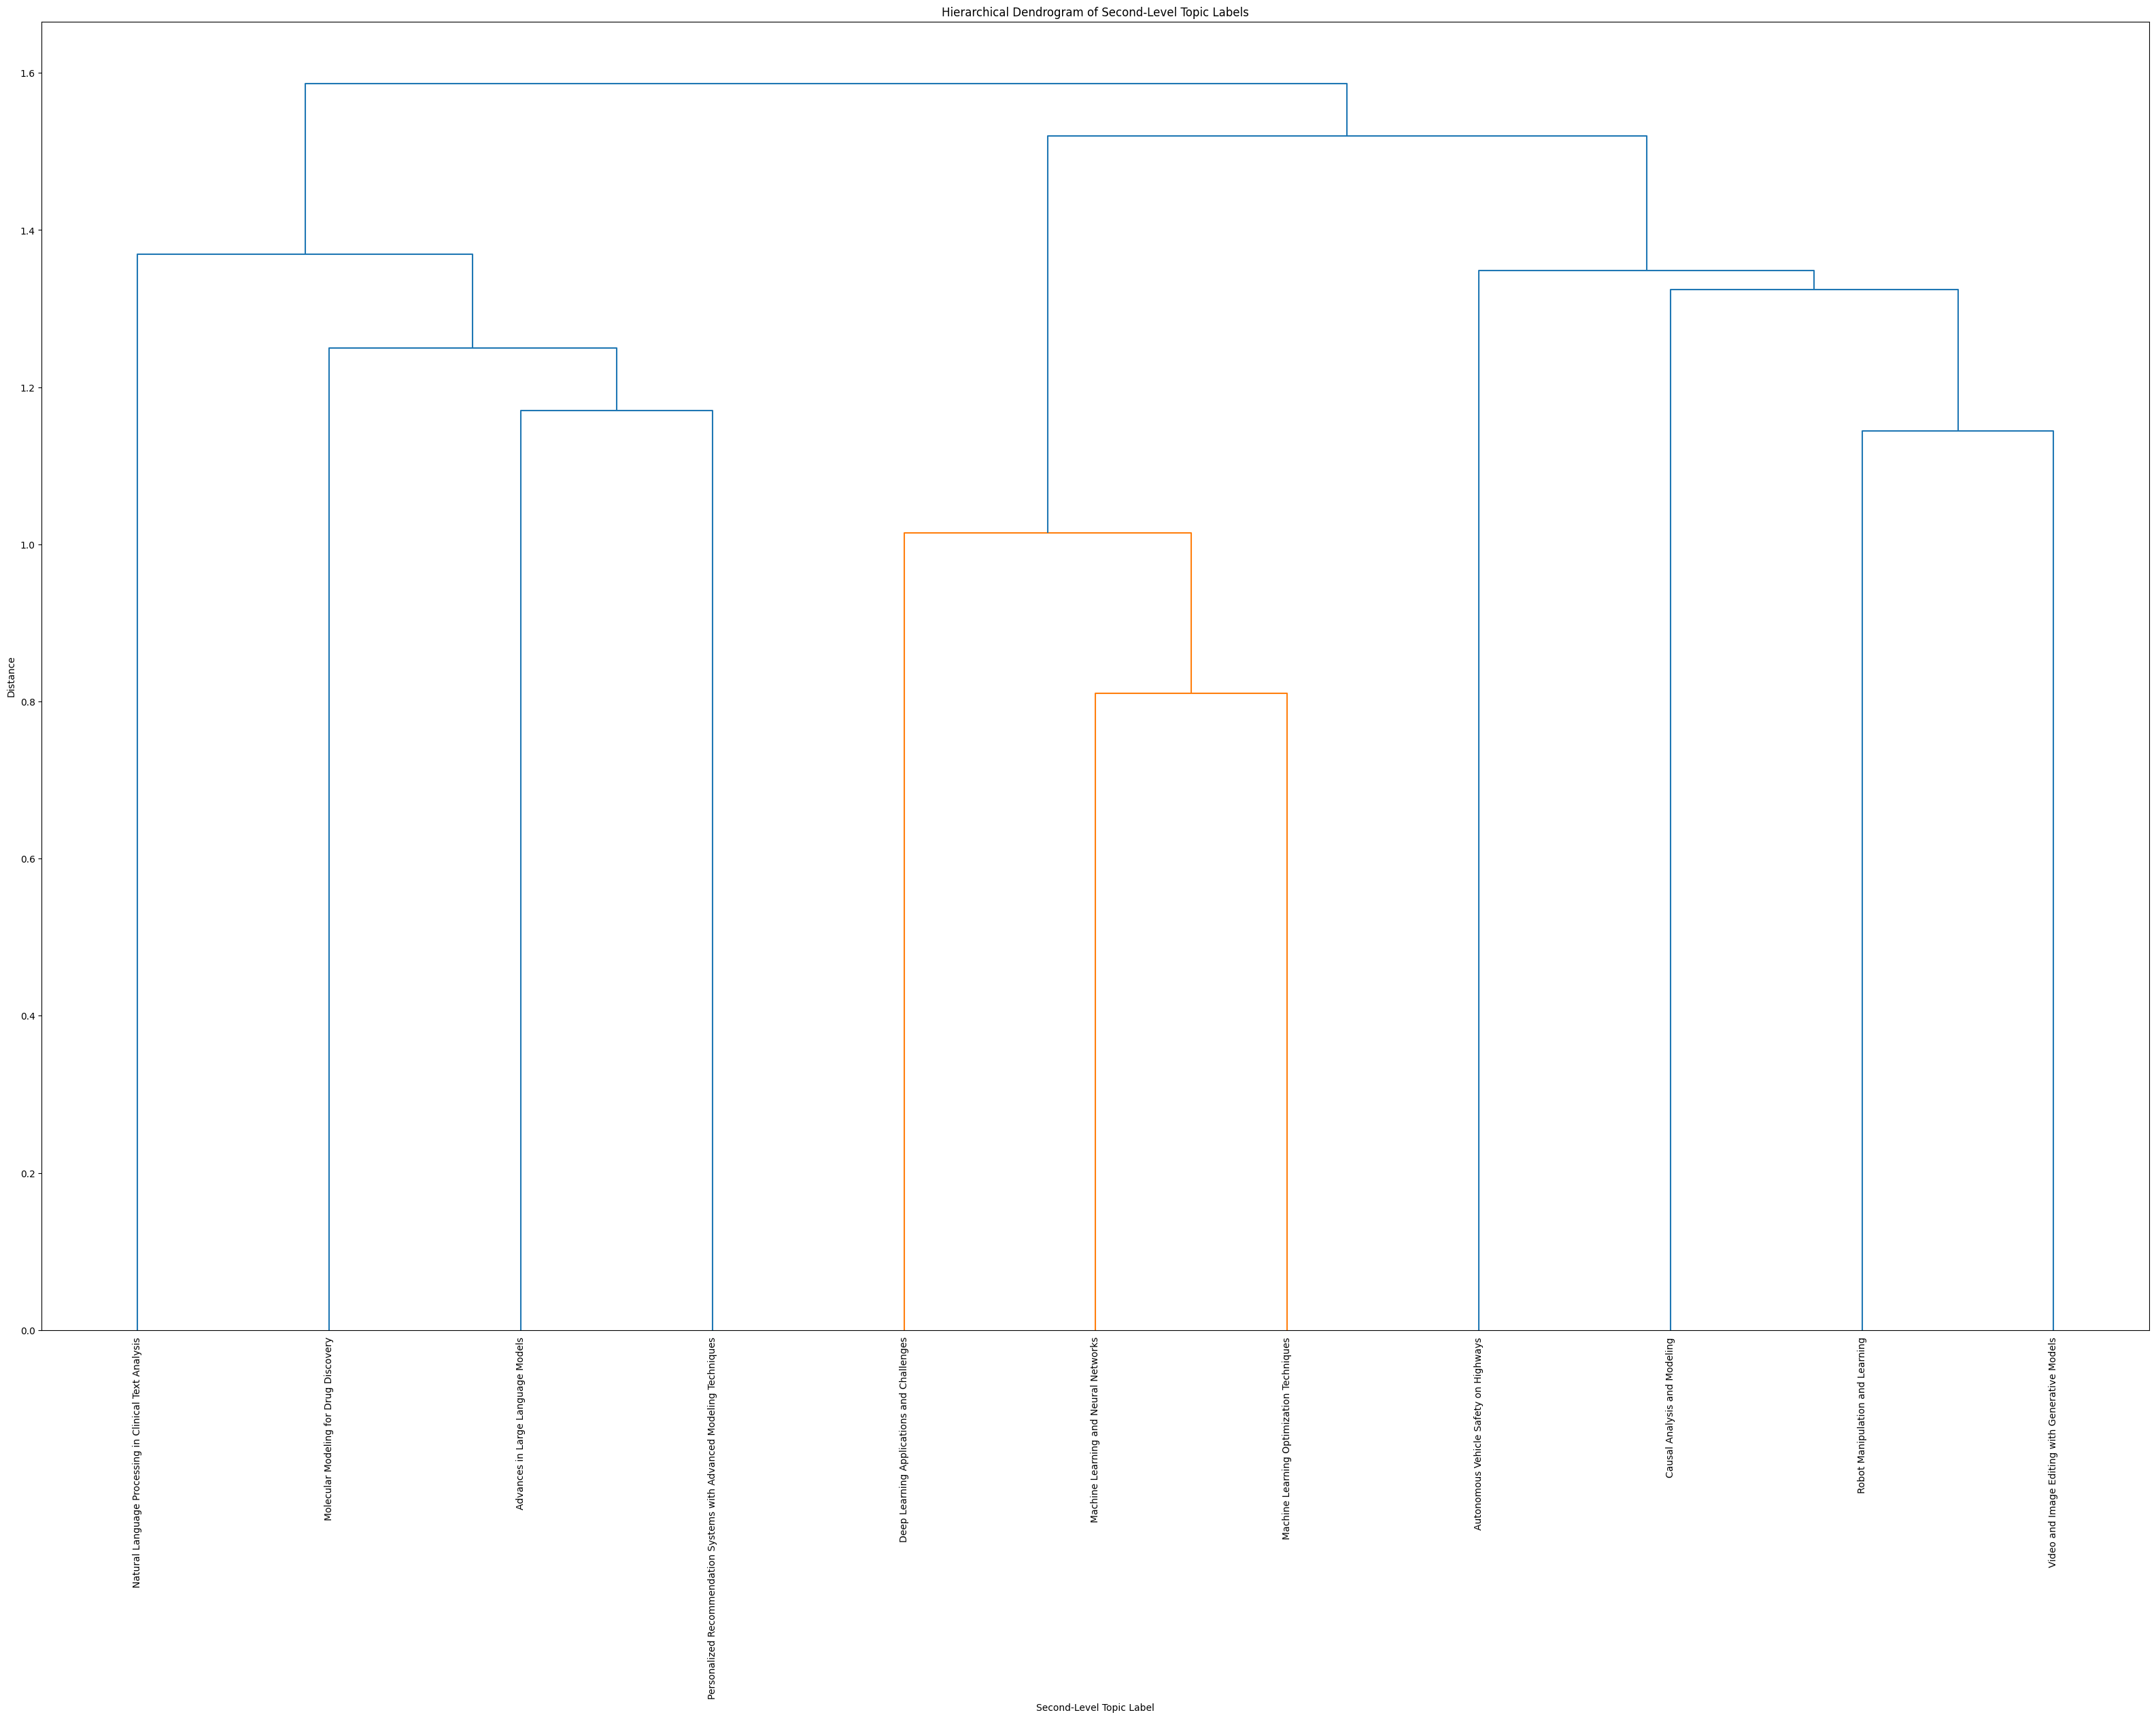

Grouping second-level topics by cluster


Generating highest-level topic labels:  71%|███████▏  | 5/7 [00:05<00:02,  1.21s/it]

Unexpected chunk format: id='chat-9f2520cbf20340e59883a4aa2324233d' object=<ObjectType.ChatCompletionChunk: 'chat.completion.chunk'> created=1727871233 model='meta-llama/Meta-Llama-3.1-70B-Instruct' choices=[] finish_reason=None usage=UsageData(prompt_tokens=7175, completion_tokens=6, total_tokens=7181)


Finding representative documents: 100%|██████████| 7/7 [00:00<00:00, 4668.49it/s]

Highest-level topic labels with representations saved to Hierchical_Topics_Third_Level-Topics.csv


In [6]:
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
from sentence_transformers import SentenceTransformer
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
import matplotlib.pyplot as plt
from together import Together
from tqdm import tqdm

# Initialize the language model client
client = Together(api_key='')

# Load the CSV file containing the second-level topic labels
df = pd.read_csv('Hierchical_Topics_Second_Level-Topics.csv')

# Initialize the sentence transformer model for embeddings
model = SentenceTransformer('all-MiniLM-L6-v2')

# Function to generate the highest-level topic label using Together AI
def generate_highest_topic_label_together(second_level_topics, keywords, representative_docs):
    prompt = (
        f"You are an intelligent assistant skilled in generating overarching labels for high-level topics. "
        f"Given the following details about a set of topics:\n"
        f"Second-Level Topics: {second_level_topics}\n"
        f"Representative Documents: {representative_docs}\n"
        f"Keywords: {keywords}\n"
        f"Please generate a concise, human-readable, supertopic label that encompasses these topics into a broad, overarching category. "
        f"Focus on capturing the most general theme without delving into specifics. "
        f"Return only the supertopic label, nothing else!"
    )

    try:
        stream = client.chat.completions.create(
            model="meta-llama/Meta-Llama-3.1-70B-Instruct-Turbo",
            messages=[{"role": "user", "content": prompt}],
            stream=True,
            temperature=0.1,
        )

        response = ""
        for chunk in stream:
            # Check if the chunk contains the expected structure
            if hasattr(chunk, 'choices') and len(chunk.choices) > 0 and hasattr(chunk.choices[0], 'delta'):
                response += chunk.choices[0].delta.content or ""
            else:
                print(f"Unexpected chunk format: {chunk}")  # Log the unexpected chunk

        if not response:
            print("No response received from the Together AI API.")
            return "Unknown"

        return response.strip()

    except Exception as e:
        print(f"An error occurred during the API call: {e}")
        return "Unknown"

# Function to find the representative document
def find_representative_document(embeddings, second_level_topics):
    centroid = np.mean(embeddings, axis=0)
    similarities = cosine_similarity([centroid], embeddings)
    most_representative_idx = np.argmax(similarities)
    return second_level_topics[most_representative_idx]

# Compute embeddings for each Second_Level_Topic_Label
tqdm.pandas(desc="Computing embeddings")
df['Embeddings'] = df['Second_Level_Topic_Label'].progress_apply(lambda x: model.encode(x))

# Perform hierarchical clustering using Ward's method
print("Performing hierarchical clustering")
Z = linkage(np.vstack(df['Embeddings']), method='ward')

# Plot the dendrogram (optional)
plt.figure(figsize=(40, 25))
dendrogram(Z, labels=df['Second_Level_Topic_Label'].values, leaf_rotation=90, leaf_font_size=10)
plt.title("Hierarchical Dendrogram of Second-Level Topic Labels")
plt.xlabel("Second-Level Topic Label")
plt.ylabel("Distance")
plt.show()

# Cutting the dendrogram at a specific distance
cut_height = 1.2  # Adjust this value based on your dendrogram
df['Cluster_Label'] = fcluster(Z, cut_height, criterion='distance')

# Group data based on the Cluster_Label
print("Grouping second-level topics by cluster")
grouped_second_level_topics = df.groupby('Cluster_Label').agg({
    'Second_Level_Topic_Label': lambda x: ' ; '.join(x),
    'Embeddings': lambda x: np.vstack(x),
    'Representation': lambda x: ' ; '.join(x),  # Assuming a column 'Keywords' exists in your dataframe
    'Representative_Docs': lambda x: ' ; '.join(x)   # Assuming a column 'Representative_Document' exists in your dataframe
}).reset_index()

# Generate the highest-level topic labels using Together AI
tqdm.pandas(desc="Generating highest-level topic labels")
grouped_second_level_topics['Highest_Topic_Label'] = grouped_second_level_topics.progress_apply(
    lambda row: generate_highest_topic_label_together(
        row['Second_Level_Topic_Label'], 
        row['Representation'], 
        row['Representative_Docs']
    ), axis=1
)

# Find the representative document for each highest-level cluster
tqdm.pandas(desc="Finding representative documents")
grouped_second_level_topics['Representative_Document'] = grouped_second_level_topics.progress_apply(
    lambda row: find_representative_document(row['Embeddings'], row['Second_Level_Topic_Label'].split(' ; ')), axis=1
)

# Save the result to a new CSV file
grouped_second_level_topics.drop(columns=['Embeddings']).to_csv('Hierchical_Topics_Third_Level-Topics.csv', index=False)

print("Highest-level topic labels with representations saved to Hierchical_Topics_Third_Level-Topics.csv")
